In [4]:
import pandas as pd
import scipy.misc
import random
import numpy as np
import cv2
import time
import pickle 

#read data.txt
driving_log=pd.read_csv('./data/driving_log.csv').sample(frac=1.0)

driving_log.describe()

df_no_zero = driving_log[driving_log.steering != 0]
df_zero = driving_log[driving_log.steering == 0]

print("Non-zero steering data: %d"%(len(df_no_zero)))
print("Zero steering angle data: %d"%(len(df_zero)))
df = df_no_zero.append(df_zero.sample(frac=0.085))
print("Total data set: %d"%(len(df)))

df[['center','left','right','steering']].to_csv('./data/trimmed_driving_log.csv',index=False)

gallery = {}
def savetoGallery(string):
    assert(string is not None)
    string = string.strip()
    img = cv2.imread('./data/' + string)
    gallery[string] = img

images = driving_log[['center','left','right']].as_matrix()
for row in images:
    savetoGallery(row[0])
    savetoGallery(row[1])
    savetoGallery(row[2])

print('total number: {}'.format(len(gallery)))
f = open('./gallery.p', 'wb')   
pickle.dump(gallery, f)      
f.close() 

total number: 24108


In [33]:
#get number of images
num_images = len(df)

#split train/validation data set
#msk = np.random.rand(num_images) < 0.8
#train = df[msk]
#valid = df[~msk]

#print('total number: {}, reserved for training: {}, validation: {}'.format(num_images, len(train), len(valid)))

def LoadTrainBatch(batch_size):
    offset = 0.2
    
    x_out = []
    y_out = []
    batch = df.sample(batch_size).as_matrix()
    
    for row in batch:
        x_out.append('./data/' + row[0].strip())
        y_out.append(row[3])
        
        # add left image
        x_out.append('./data/' + row[1].strip())
        y_out.append(min(1, row[3] + offset))
        
        # add right image
        x_out.append('./data/' + row[2].strip())
        y_out.append(max(-1, row[3] - offset))
        
        # flip horizontal
        x_out.append('./data/' + row[0].strip())
        y_out.append(- row[3])
        
        # add left image
        x_out.append('./data/' + row[1].strip())
        y_out.append(- min(1, row[3] + offset))
        
        # add right image
        x_out.append('./data/' + row[2].strip())
        y_out.append(- max(-1, row[3] - offset))
        
    print(len(x_out))
    return np.array(x_out), np.array(y_out)

def LoadValBatch(batch_size):
    x_out = []
    y_out = []
    batch = valid.sample(batch_size).as_matrix()
    for row in batch:
        x_out.append(transform(scipy.misc.imread('./data/' + row[0].strip())) / 255 -0.5)
        y_out.append(row[3])
    return np.array(x_out), np.array(y_out)

#xCenter_train, y_train = LoadTrainBatch(len(train))
#xCenter_valid, y_valid = LoadTrainBatch(len(valid))

x, y = LoadTrainBatch(len(df))

23622


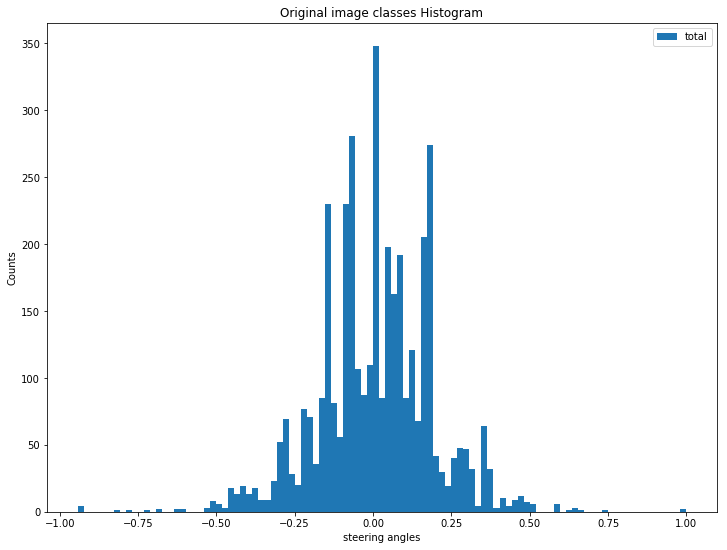

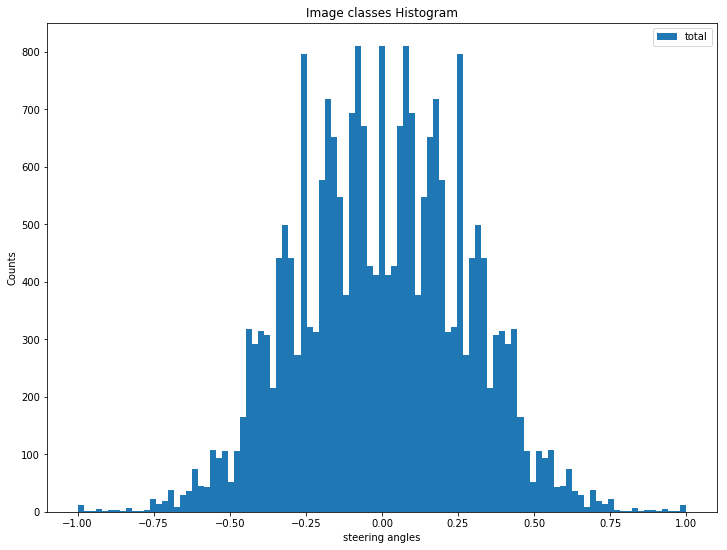

In [37]:
### inspection
import matplotlib.pyplot as plt
%matplotlib inline
def inspectHistogramOriginal():
    pltChangeSize()
    
    plt.hist(df['steering'], bins=101, label='total')

    plt.title('Original image classes Histogram')  
    plt.xlabel('steering angles')  
    plt.ylabel('Counts')  
    plt.legend()  
    plt.show()
    
def inspectHistogram():
    pltChangeSize()
    
    plt.hist(y, bins=101, label='total')

    plt.title('Image classes Histogram')  
    plt.xlabel('steering angles')  
    plt.ylabel('Counts')  
    plt.legend()  
    plt.show()
    
def pltChangeSize():
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width to 12 and height to 9
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size

inspectHistogramOriginal()
inspectHistogram()

In [26]:
print('total number: {}'.format(len(x)))
pdata = {'x':x, 'y':y}
f = open('./data.p', 'wb')   
pickle.dump(pdata, f)      
f.close() 

total number: 7830


In [ ]:


def frange(start, end, step):
    while start < end:
        yield start
        start += step
        
def plotImagesPerClass():
    pltChangeSize()
    step = 0.2
    classes = frange(-1.1, 1.1, step)

    for cls in classes:
        fig, axes = plt.subplots(ncols=3, figsize=(18, 4))
        ceil = cls + step
        subset = driving_log.loc[(driving_log['steering'] >= cls) & (driving_log['steering'] < ceil)]
        print("{} Steering angle between {:.1f} and {:.1f}".format(len(subset), cls, ceil))
        
        if len(subset)>0:
            idx = subset.sample(1)
            
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        print('./data/' + idx['left'].iloc[0].strip())
        axes[0].imshow(cv2.resize(scipy.misc.imread('./data/' + idx['left'].iloc[0].strip()),(96,48)))

        axes[1].set_xticks([])
        axes[1].set_yticks([])
        axes[1].imshow(scipy.misc.imread('./data/' + idx['center'].iloc[0].strip()))

        axes[2].set_xticks([])
        axes[2].set_yticks([])
        axes[2].imshow(scipy.misc.imread('./data/' + idx['right'].iloc[0].strip()))


        plt.show()
            

    
plotImagesPerClass()

In [3]:
pts1 = np.float32([[140,60],[180,60],[0,100],[320,100]])
pts2 = np.float32([[140,0],[180,0],[0,120],[320,120]])

M = cv2.getPerspectiveTransform(pts1,pts2)

def transform(img):
    dst = cv2.warpPerspective(img,M,(320,160))
    dst = cv2.resize(dst, (64,64))
    return dst